In [1]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: Error requiring `StaticArrays` from `ArrayInterface`
│   exception = (ErrorException("too many parameters for type"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000068f84117, Ptr{Nothing} @0x0000000068ff06a9, Ptr{Nothing} @0x000000006901236c, Ptr{Nothing} @0x0000000069012031, Ptr{Nothing} @0x0000000069012b40, Ptr{Nothing} @0x0000000069013515, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 82, Ptr{Nothing} @0x0000000069030c9d, Ptr{Nothing} @0x000000006903241a, Ptr{Nothing} @0x0000000019a10bef, Ptr{Nothing} @0x0000000019a10c13, Ptr{Nothing} @0x00000000199f6531, Ptr{Nothing} @0x0000000019a10b3a, Ptr{Nothing} @0x0000000019a10b63, Ptr{Nothing} @0x00000000199f5e98, Ptr{Nothing} @0x0000000019a10aa1, Ptr{Nothing} @0x0000000019a10ad3, Ptr{Nothing} @0x00000000199f1a8e, Ptr{Nothing} @0x00000000199f89f4, Ptr{Nothing} @0x00000000199f8d13, Ptr{Nothing} @0x0000000069030130, Ptr{Nothing} @0x0000000069026590, Ptr{Nothing} @0x000000001995a107, Ptr{No

In [2]:
using Plots
gr()  

Plots.GRBackend()

## thickness
### test liquid h and vapor h in a one-loop OHP heating problem-with no dynamics
### plate temperature:  constant uniform 296 K, tube initial temperature uniform 295 K 

### conduction only

# Properies

### Earth property

In [3]:
g = 9.8

9.8

### Solid Physical parameters

In [4]:
ρₛ = 2700; # density
cₛ  = 8.97e02; # specific heat
kₛ  = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 2e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Fluid Physical parameters

In [5]:
fluid_type = "butane"
Tᵥ = 291.0

291.0

In [6]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [7]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [8]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [9]:
inch = 2.54e-2;

In [10]:
power = 40 #watts
total_heater_area = 2.0inch*2.0inch;

In [11]:
qe = power/total_heater_area
hc = 1500.0
Tc = Tᵥ

291.0

In [12]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [13]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = 1e-3
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
# one_loop_gap = 1e-2
# x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 5598 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


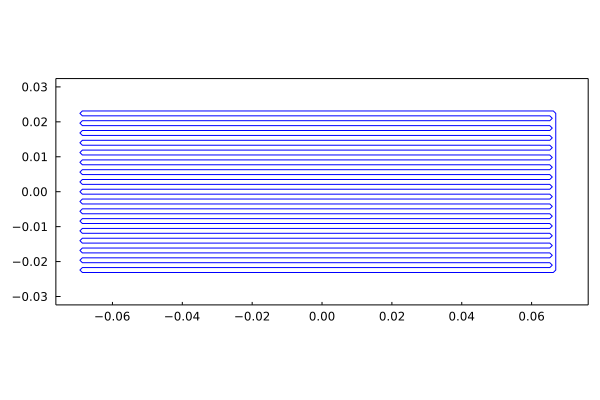

In [14]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [15]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{5598,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 5598 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [16]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


In [17]:
qtmp = zeros(numpts(ohp));

In [18]:
u0 = newstate(sys)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator) .+ Tᵥ;

In [19]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


In [20]:
num = 100
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

  2.879980 seconds (2.74 M allocations: 1.446 GiB, 7.71% gc time)


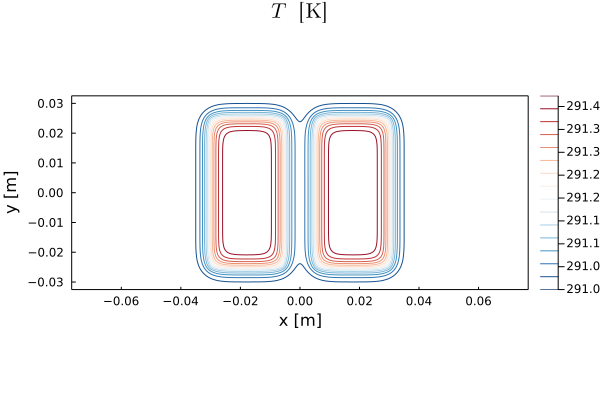

In [21]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

# OHP inner part

### Tube geometries

In [22]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [23]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [24]:
Nu = 4.36
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

469.522228765219

In [25]:
X0,realratio = randomXp(L,numofslugs=30,chargeratio=0.45)
# X0 = [(L/2,L/2+L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [26]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [27]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [124]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
δ = 0*zeros(length(X0)) .+ 10.0e-5;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

### Wall

### nucleate boiling sites

In [125]:
ΔTthres = 5.0; # superheat threshold

In [126]:
    nucleatenum = 256
#     Xstations = sort(rand(nucleatenum).*L);
    Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

256-element LinRange{Float64}:
 0.0,0.0181679,0.0363357,0.0545036,…,4.56013,4.5783,4.59647,4.61464,4.6328

In [127]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [128]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [129]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [130]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [131]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [132]:
tspan = (0.0, 10.0);
dt_record = tspan[2] /20;
# dt_record = 0.1;

tstep=2e-4

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [133]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ;

In [134]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [135]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [136]:
integrator_tube.t

0.0

In [137]:

@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.4999999999999776
0.9999999999999225


1.4999999999998674
1.9999999999998124
merged!
2.4999999999997575
merged!
merged!
merged!
2.9999999999997025
merged!
merged!
merged!
3.4999999999996474
merged!
merged!
3.9999999999995923
merged!
4.5000000000006475
merged!
merged!
merged!
merged!
5.000000000001703
5.500000000002758
merged!
6.000000000003813
merged!
6.500000000004868
merged!
7.000000000005923
merged!
7.500000000006978
8.000000000008033
8.500000000006867
9.000000000005702
9.500000000004537
10.000000000003372
2752.344617 seconds (2.42 G allocations: 2.980 TiB, 21.49% gc time)


In [139]:
L

4.650971776737257

In [140]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
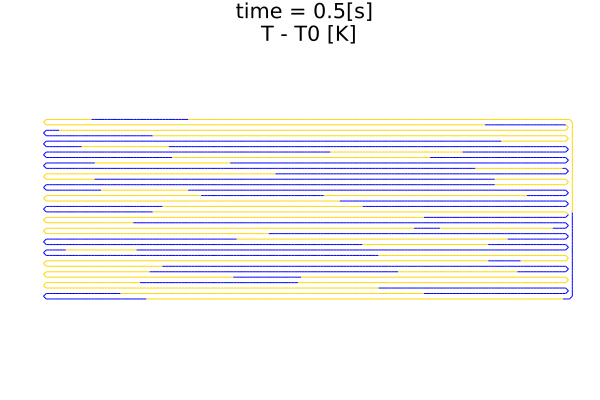

In [141]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

# plot the OHP

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
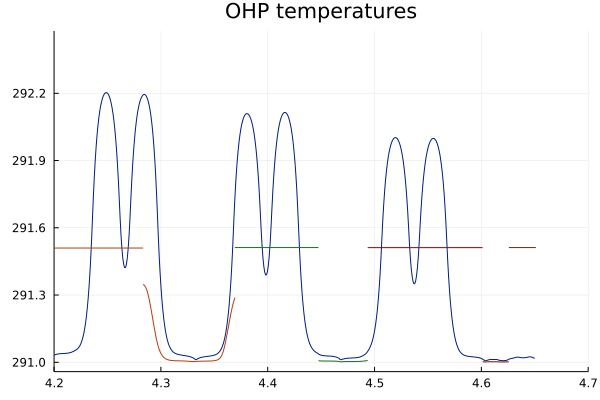

In [142]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",xlim=(4.2,4.7))
end

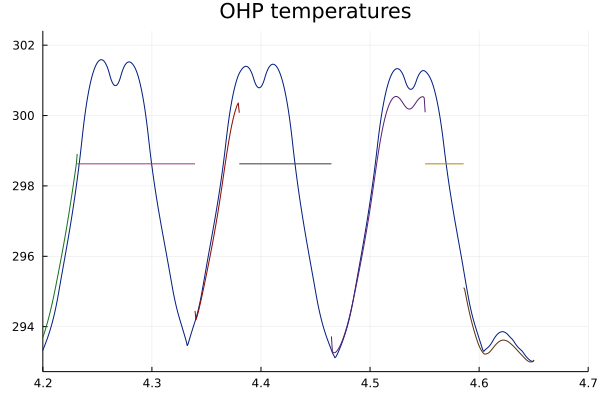

In [143]:
plot(sysfinal[end],plottype="T",xlim=(4.2,4.7))

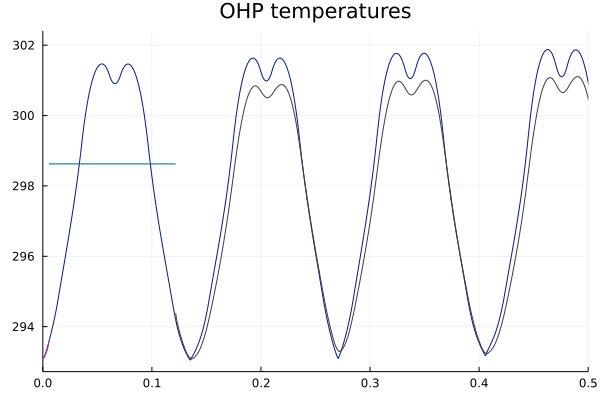

In [144]:
plot(sysfinal[end],plottype="T",xlim=(0.0,0.5))

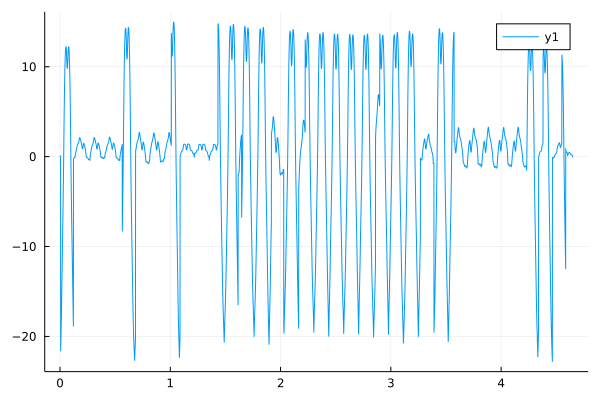

In [145]:
plot(sys.qline[1].arccoord,sys.qline[1].q)

In [146]:
p.wall.Xstations[153]

2.7615144924377466

In [147]:
sysfinal[end].liquid.Xp

12-element Array{Tuple{Float64,Float64},1}:
 (3.2681011804923394, 3.3911834361908286)
 (3.5734926936231988, 4.231508514725564)
 (4.339512242587971, 4.380082757691952)
 (4.4645853354665865, 4.550516506106785)
 (4.585838115222198, 0.005500324344804188)
 (0.12179400513512897, 0.5643700732678792)
 (0.6851334472935544, 1.009882786868541)
 (1.0889197387951788, 1.432655604253384)
 (1.6153942728341528, 1.6468851487113305)
 (1.9169009908774317, 2.0289344453085487)
 (2.1646449235689285, 2.222829075703569)
 (2.8609642408127973, 2.8989023244556575)

In [148]:
getsuperheat(p.wall.Xstations[154],p)

0.0

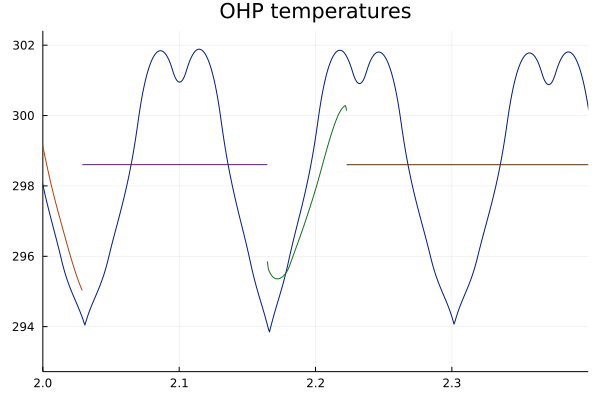

In [149]:
plot(sysfinal[end],plottype="T",xlim=(2.0,2.4))
# plot!([0,L],[ΔTthres,ΔTthres])

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
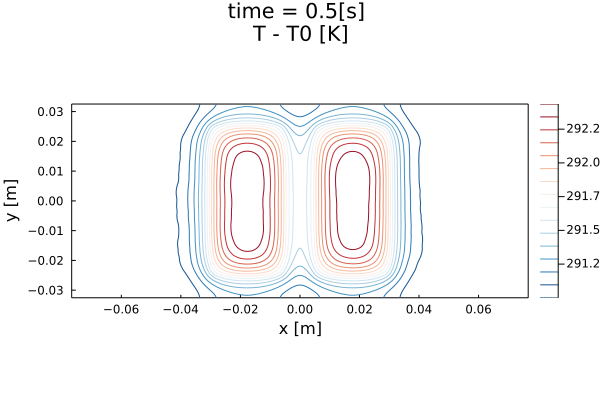

In [150]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = 0.0
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"))
end

In [151]:
paraₗ = 4*Hₗ/(tube_d*ρₗ*Cpₗ)
t = LinRange(tspan[1],tspan[2],length(sysfinal))

Thist_refₗ = (Tᵥ + 1.0) .- exp.(-paraₗ .* (t .- t[1]));


In [152]:
Verification_Thist

100-element Array{Float64,1}:
 291.0
 291.27046829440206
 291.24295811054236
 292.750219697486
 292.7196555219111
 293.2625402224047
 293.7848617796732
 294.14862637078613
 294.4394474223881
 295.3348342353994
 296.0084757263905
 296.4883463646058
 296.3706633528213
   ⋮
 309.324389022085
 308.5278938599053
 308.2731285489964
 308.2485942703243
 308.36627864730843
 308.47453522960217
 308.5864849577924
 308.7036709613065
 308.82201888192833
 308.938610225472
 309.043891117921
 309.13745371606865

In [153]:
Verification_Thist = zeros(length(sysfinal))
Verification_Thist[1] = Tᵥ
for i = 1:length(sysfinal)-1
    Verification_Thist[i+1] = (maximum(sysfinal[i].liquid.θarrays[1]))
end

In [154]:
err = norm(Verification_Thist - Thist_refₗ,Inf)

8.354601023291423

In [155]:
y=[]

Any[]

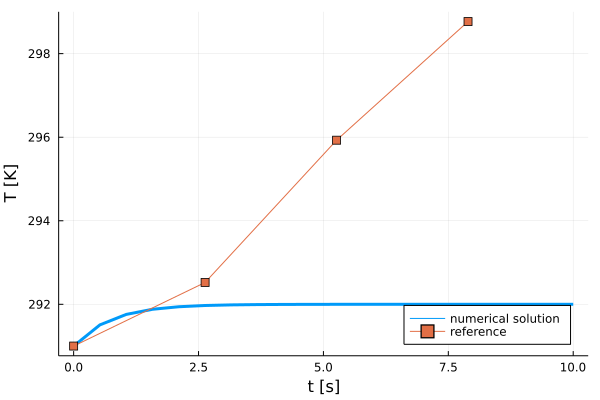

In [156]:
plot(t,Thist_refₗ,linewidth=3.0,label="numerical solution")
plot!(t[1:5:end],Verification_Thist[1:5:end],ylabel="T [K]",xlabel="t [s]",markershape=:auto,label="reference",legend=:bottomright)
# savefig("validation.pdf")

In [157]:
Lliquidslug = XptoLliquidslug(sys0.liquid.Xp,sys0.tube.L)

30-element Array{Float64,1}:
 0.006666959807669404
 0.09247783678989396
 0.13227278494445827
 0.13188781117309034
 0.09278889464627982
 0.008671782660708338
 0.11809284615090476
 0.06434991804509327
 0.017473946691971776
 0.040570515103980576
 0.0859311706401984
 0.046059448805291225
 0.024574537054445678
 ⋮
 0.10690582392173287
 0.12266540640241619
 0.12437606062174211
 0.07770787255081135
 0.10284142082153558
 0.13166991926260874
 0.10922452537406091
 0.03149087587717769
 0.11203345443116053
 0.058184152134640676
 0.03793808364286022
 0.11641529589082023

In [158]:
save("plate_OHP_dimensional50D5.0TH5.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [159]:
save("tube_OHP_dimensional50D5.0TH5.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [160]:
# plate_hist, integrator_plate = load("plate_OHP_dimensional50D1.0.jld2", "plate_hist",  "integrator_plate")
# sys = integrator_plate.p

In [161]:
# tube_hist, integrator_tube = load("tube_OHP_dimensional50D1.0.jld2", "tube_hist",  "integrator_tube")

# sysfinal = []
# for i = 1:length(tube_hist)
#     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# end

In [162]:
RTDy=[291.2
292.7
294
295
295.6
296.3
296.8
297.3
297.7
298.1
298.2
298.5
298.8
298.9
299.1
299.3
299.3
299.4
299.7
299.7
299.7
299.8
300
300.1
300.1
300.3
300.4
300.4
300.4
300.6
300.6
300.6
300.7
300.8
300.8
300.8
300.9
301
301.1
301
301
301.2
301.2
301.3
301.2
301.3
301.4
301.4
301.4
301.5
301.4
301.7
301.6
301.6
]

54-element Array{Float64,1}:
 291.2
 292.7
 294.0
 295.0
 295.6
 296.3
 296.8
 297.3
 297.7
 298.1
 298.2
 298.5
 298.8
   ⋮
 301.2
 301.3
 301.2
 301.3
 301.4
 301.4
 301.4
 301.5
 301.4
 301.7
 301.6
 301.6

In [163]:
RTDx=0:53

0:53

In [164]:
x = [0.0]
y = [0.0]

X =  VectorData(x,y);

In [165]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [166]:
ghist = []
thist = []
for i = 1:length(plate_hist)
    H(g,temperature(plate_hist[i]))
    append!(ghist,deepcopy(g))
    append!(thist,plate_hist[i].t)
end

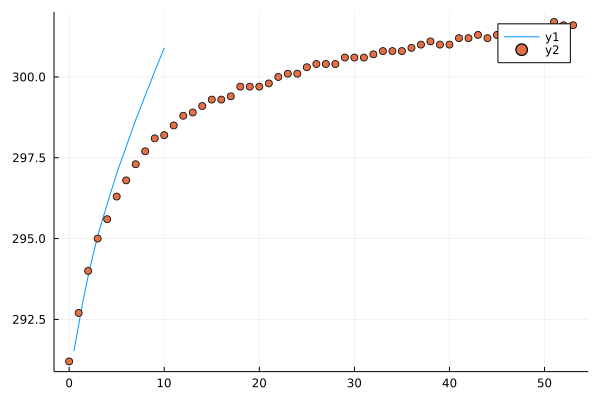

In [167]:
plot(thist,ghist)
scatter!(RTDx,RTDy)

In [168]:
integrator_tube.p.vapor

Vapor(0.10768858457917865, [246738.22794382367, 246750.0688956264, 246921.95811709436, 246926.06389069173, 246923.20761698118, 246915.27132834602, 246846.5123828144, 246789.2535341588, 246768.72404311283, 246768.04744181648, 246751.78937708336, 246740.89625036478], [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001])

In [169]:
Xarrays=Array{Float64, 1}
Xarrays = [1,2,3,4,5]


5-element Array{Int64,1}:
 1
 2
 3
 4
 5

In [170]:
    Lliquid = XptoLliquidslug(X0,L)


30-element Array{Float64,1}:
 0.006666959807669404
 0.09247783678989396
 0.13227278494445827
 0.13188781117309034
 0.09278889464627982
 0.008671782660708338
 0.11809284615090476
 0.06434991804509327
 0.017473946691971776
 0.040570515103980576
 0.0859311706401984
 0.046059448805291225
 0.024574537054445678
 ⋮
 0.10690582392173287
 0.12266540640241619
 0.12437606062174211
 0.07770787255081135
 0.10284142082153558
 0.13166991926260874
 0.10922452537406091
 0.03149087587717769
 0.11203345443116053
 0.058184152134640676
 0.03793808364286022
 0.11641529589082023